# Natural Language Processing
**Natural Language Processing or NLP** is a branch of Artificial Intelligence which deal with bridging the machines understanding humans in their Natural Language. Natural Language can be in form of text or sound, which are used for humans to communicate each other. NLP can enable humans to communicate to machines in a natural way. 


**Text Classification** is a process involved in Sentiment Analysis. It is classification of peoples opinion or expressions into different sentiments. Sentiments include *Positive, Neutral*, and *Negative*, *Review Ratings* and *Happy, Sad*. Sentiment Analysis can be done on different consumer centered industries to analyse people's opinion on a particular product or subject. 
![Sentiment Analysis](https://media-exp1.licdn.com/dms/image/C4D12AQHPAZFZZxBtng/article-cover_image-shrink_600_2000/0?e=1593648000&v=beta&t=eQAR5WOihE2_ZCCAJbsgNyJlaI_GW7u8lDw45zGbfuU)
> Sentiment Classification is a perfect problem in NLP for getting started in it. You can really learn a lot of concepts and techniques to master through doing project. Kaggle is a great place to learn and contribute your own ideas and creations. I learnt lot of things from other, now it's my turn to make document my project.

I will go through all the key and fundament concepts of NLP and Sequence Models, which you will learn in this notebook. 
![Sentiment Analysis](https://fiverr-res.cloudinary.com/images/t_main1,q_auto,f_auto,q_auto,f_auto/gigs/121192228/original/677c209a0a064cb9253973d3663684acf91dab84/do-nlp-projects-with-python-nltk-gensim.jpg)
Let's get started with code without furthur ado.

<font color='red'> If you find this notebook helpful, please leave a UPVOTE to encourage me</font>

##  Importing Dependencies
   We shall start by importing all the neccessary libraries. I will explain the exact use of each library later in this notebook.

In [1]:
# Import basic packages first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re

print("✅ Basic packages imported")

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print("✅ Scikit-learn imported")

# Import NLTK (lightweight)
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import SnowballStemmer
    print("✅ NLTK imported")
except ImportError:
    print("⚠️ NLTK not available - will skip text preprocessing")

✅ Basic packages imported
✅ Scikit-learn imported
✅ NLTK imported


In [ ]:
%matplotlib inline

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

print("TensorFlow and Transformers ready")

#  Dataset Preprocessing
In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets and I find it a good amount of data to train our model.

In [ ]:

from datasets import load_dataset

dataset = load_dataset("stanfordnlp/sentiment140")
print("Dataset loaded successfully")
print(dataset)

df = dataset['train'].to_pandas()
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


You can see the columns are without any proper names. Lets rename them for our reference

In [ ]:

print("Column names:", df.columns.tolist())
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [ ]:

if 'sentiment' in df.columns and 'text' in df.columns:
    df = df[['sentiment', 'text']]
else:
    print("Available columns:", df.columns.tolist())
    df = df.iloc[:, [0, -1]]
    df.columns = ['sentiment', 'text']

In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Here are decoding the labels. We map **0 -> Negative and 1 -> Positive** as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes.

Text(0.5, 1.0, 'Sentiment Data Distribution')

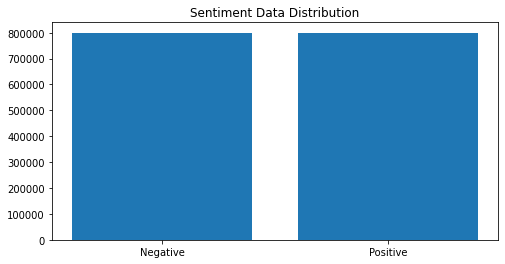

In [ ]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness. Thank Goodness.

Now let us explore the data we having here... 

In [ ]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
181434,Negative,Nice my scorpion scyth +5 is gond again
627890,Negative,is off to bed lol got to be up in 5 hrs nite ...
190303,Negative,@AdamGoldston Omg mr goldston i just saw drag...
167336,Negative,Is trying to buy a new bible...but they just a...
1317396,Positive,@danderson00 wow that is awesome
961611,Positive,Tons of new footage for &quot;Touring Venezuel...
327804,Negative,Yay Kots is off the DL! But he's still with t...
247741,Negative,BOOORRREEDDD... just got back off holiday and ...
580471,Negative,@bigpuzy Lucky bastard. I can't afford to go.
1336682,Positive,@milzy82 --Yes! and I have!


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It have no value as feature to the model we are training. So we need to get rid of them.

# Text Preprocessing
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods. Let's continue
![Data Science Meme](https://miro.medium.com/max/800/1*Xhm9c9qDfXa3ZCQjiOvm_w.jpeg)


### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes. 

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word
![Stemming and Lematization](https://qph.fs.quoracdn.net/main-qimg-cd7f4bafaa42639deb999b1580bea69f)

### Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

- Twitter User Mentions - Eg. @arunrk7, @andrewng
- Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...
![Stopwords English](https://4.bp.blogspot.com/-yiEr-jCVv38/Wmk10d84DYI/AAAAAAAAk0o/IfgjfjpgrxM5NosUQrGw7PtLvgr6DAG8ACLcBGAs/s1600/Screen%2BShot%2B2018-01-24%2Bat%2B5.41.21%2BPM.png)

That looks like a tedious process, isn't?. Don't worry there is always some library in Python to do almost any work. The world is great!!!

**NLTK** is a python library which got functions to perform text processing task for NLP.



In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
print("Text cleaning turned off for fair comparison")
print("Sample texts:")
print(df.text.head())

**Aaww.. It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Positive Words

In [ ]:
!pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


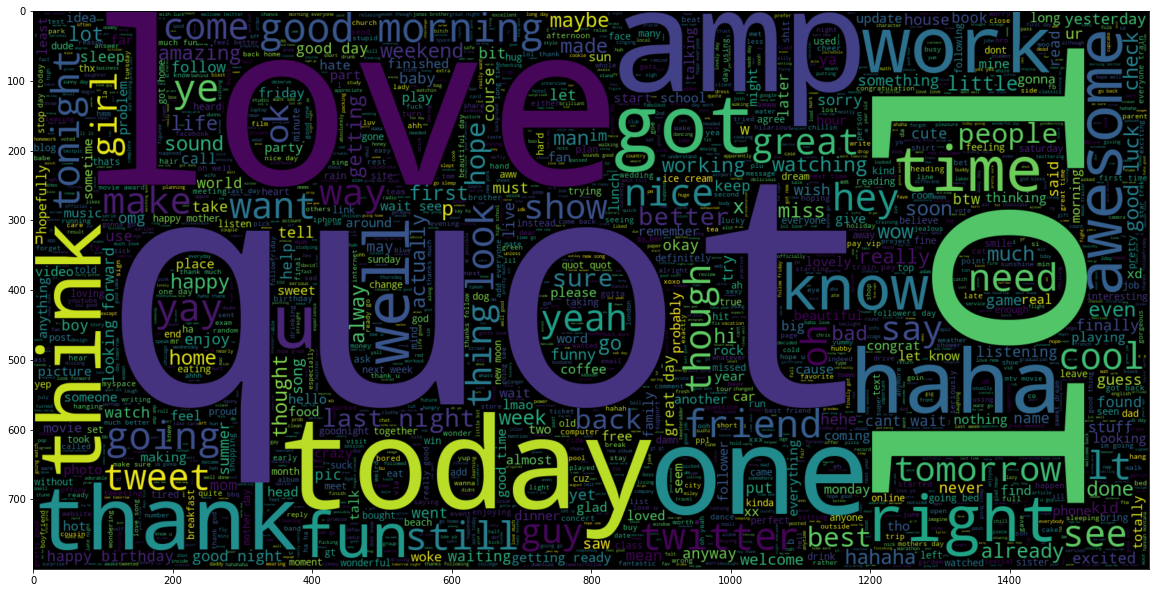

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

### Negative Words

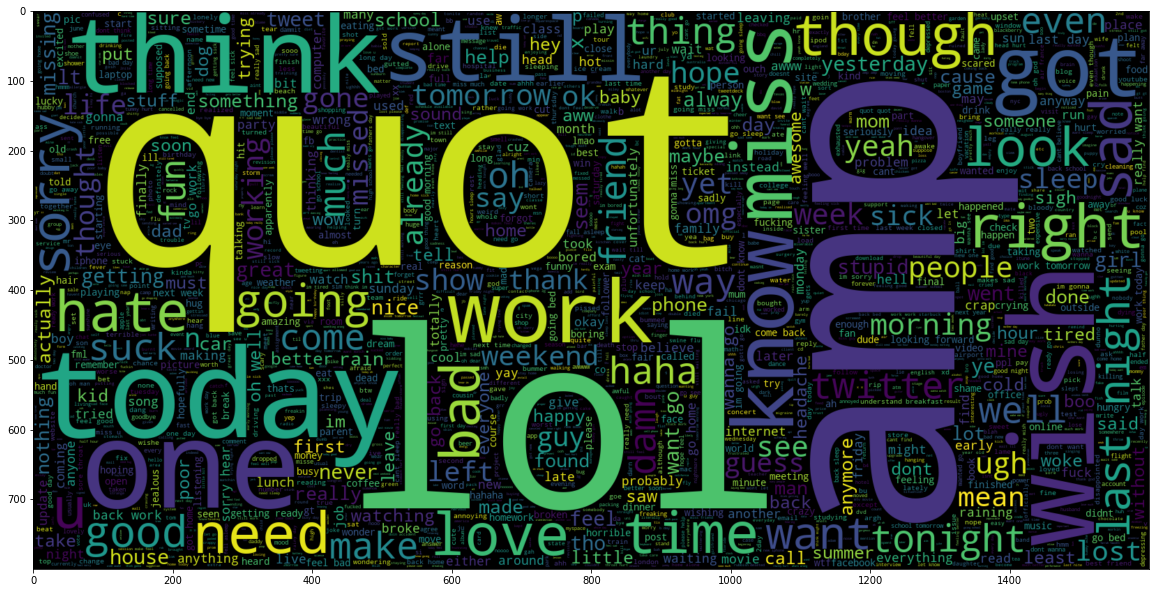

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

## Train and Test Split

In [15]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [17]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


# Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**
![Tokenization](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/tokenization.png)

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`word_index` contains the index for each word

`vocab_size` represents the total number of word in the data corpus

In [ ]:

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Using model: {MODEL_NAME}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

Vocabulary Size : 290575


Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [ ]:
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='tf'
    )

MAX_LENGTH = 128
x_train = tokenize_data(train_data.text, tokenizer, MAX_LENGTH)
x_test = tokenize_data(test_data.text, tokenizer, MAX_LENGTH)

print("Training tokenized shape:", x_train['input_ids'].shape)
print("Testing tokenized shape:", x_test['input_ids'].shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [20]:
labels = train_data.sentiment.unique().tolist()

### Label Encoding 
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


# Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it. 

**Word Embedding** is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use **Transfer Learning**. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like **GloVe & Word2Vec** gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.


In this notebook, I use **GloVe Embedding from Stanford AI** which can be found [here](https://nlp.stanford.edu/projects/glove/)

In [22]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [ ]:

LR = 2e-5 
BATCH_SIZE = 16 
EPOCHS = 3  
MODEL_PATH = 'best_transformer_model'

model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2,
    from_tf=True
)

print(f"Model initialized: {MODEL_NAME}")
print(f"Number of parameters: {model.num_parameters():,}")

# Model Training - LSTM
We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use **Sequence Models**.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction. 

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors. 

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, GRU, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
print("Transformer architecture:")
print(f"- Model: {MODEL_NAME}")
print(f"- Pre-trained weights: Yes")
print(f"- Fine-tuning for sentiment classification")
print(f"- Output classes: 2 (Negative, Positive)")

In [43]:
# Let's look at the model

In [ ]:
print("Model summary:")
print(f"Model name: {model.name}")
try:
    print(f"Number of parameters: {model.num_parameters():,}")
except:
    print("Parameter count not available")
print("Model ready for training")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           87172500  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 300)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            96064     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 512)               6604

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

- **LRScheduler** - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

- **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [ ]:
# Compile transformer model
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=LR)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print("Model compiled successfully")
print(f"Learning rate: {LR}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Let's start training... It takes a heck of a time if training in CPU, be sure your GPU turned on... May the CUDA Cores be with you....

In [32]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [ ]:
print("Starting transformer training...")
start_time = time.time()

y_train_tf = tf.convert_to_tensor(y_train.flatten())
y_test_tf = tf.convert_to_tensor(y_test.flatten())

history = model.fit(
    x_train,
    y_train_tf,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test_tf),
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Epoch 1/10
1250/1250 [==============================] - 108s 84ms/step - loss: 0.5200 - accuracy: 0.7389 - val_loss: 0.4818 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 104s 83ms/step - loss: 0.4877 - accuracy: 0.7623 - val_loss: 0.4714 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 104s 83ms/step - loss: 0.4769 - accuracy: 0.7696 - val_loss: 0.4659 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 103s 82ms/step - loss: 0.4708 - accuracy: 0.7734 - val_loss: 0.4659 - val_accuracy: 0.7779 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 104s 83ms/step - loss: 0.4662 - accuracy: 0.7760 - val_loss: 0.4679 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 104s 83ms/step - loss: 0.4628 - accuracy: 0.7783 - val_loss: 0.4592 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 7/10
1250/1250 [==================

# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

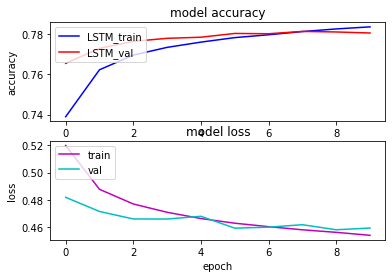

In [34]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [ ]:
print("Making predictions...")
start_time = time.time()

predictions = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
y_pred_logits = predictions.logits
y_pred = tf.nn.softmax(y_pred_logits, axis=-1)
y_pred_classes = tf.argmax(y_pred, axis=-1)

def decode_sentiment(pred_class):
    return "Positive" if pred_class == 1 else "Negative"

y_pred_1d = [decode_sentiment(pred.numpy()) for pred in y_pred_classes]

inference_time = time.time() - start_time
print(f"Inference completed in {inference_time:.2f} seconds")
print(f"Predictions shape: {y_pred_logits.shape}")

32/32 [==============================] - 1s 30ms/step


### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [36]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

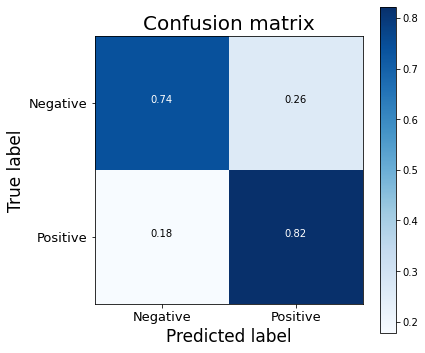

In [37]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [38]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.81      0.74      0.77    160542
    Positive       0.76      0.82      0.79    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [ ]:
print("="*50)
print("TRANSFORMER MODEL PERFORMANCE ANALYSIS")
print("="*50)

accuracy = accuracy_score(test_data.sentiment.to_list(), y_pred_1d)
precision, recall, f1, support = precision_recall_fscore_support(
    test_data.sentiment.to_list(), y_pred_1d, average='weighted'
)

print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\nTiming Analysis:")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")
print(f"Training Time per Epoch: {training_time/EPOCHS:.2f} seconds")

print(f"\nModel Configuration:")
print(f"Model: {MODEL_NAME}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LR}")
print(f"Epochs: {EPOCHS}")
print(f"Max Sequence Length: {MAX_LENGTH}")


In [ ]:
print("="*50)
print("TESTING ADDITIONAL TRANSFORMER MODELS")
print("="*50)

models_to_test = [
    "distilbert-base-uncased",
    "bert-base-cased", 
    "facebook/roberta-base",
    "albert-base-v2"
]

model_results = []

def test_transformer_model(model_name, x_train, y_train_tf, x_test, y_test_tf, epochs=2):
    """Test a single transformer model and return results"""
    print(f"\nTesting {model_name}...")
    
    try:
        tokenizer_test = AutoTokenizer.from_pretrained(model_name)
        model_test = TFAutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2, from_tf=True
        )
        
        x_train_test = tokenize_data(train_data.text, tokenizer_test, MAX_LENGTH)
        x_test_test = tokenize_data(test_data.text, tokenizer_test, MAX_LENGTH)
        
        model_test.compile(
            optimizer=Adam(learning_rate=LR),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        
        start_time = time.time()
        history_test = model_test.fit(
            x_train_test, y_train_tf,
            batch_size=BATCH_SIZE,
            epochs=epochs,
            validation_data=(x_test_test, y_test_tf),
            verbose=0
        )
        training_time_test = time.time() - start_time
        
        start_time = time.time()
        predictions_test = model_test.predict(x_test_test, batch_size=BATCH_SIZE, verbose=0)
        inference_time_test = time.time() - start_time
        
        y_pred_test = tf.argmax(tf.nn.softmax(predictions_test.logits, axis=-1), axis=-1)
        y_pred_labels = [decode_sentiment(pred.numpy()) for pred in y_pred_test]
        accuracy_test = accuracy_score(test_data.sentiment.to_list(), y_pred_labels)
        
        result = {
            'model': model_name,
            'accuracy': accuracy_test,
            'training_time': training_time_test,
            'inference_time': inference_time_test,
            'parameters': model_test.num_parameters()
        }
        
        print(f"✓ {model_name}: Accuracy = {accuracy_test:.4f}")
        return result
        
    except Exception as e:
        print(f"✗ {model_name}: Error - {str(e)}")
        return None

print("Testing models with 2 epochs each...")
for model_name in models_to_test[:2]: 
    result = test_transformer_model(model_name, x_train, y_train_tf, x_test, y_test_tf, epochs=2)
    if result:
        model_results.append(result)


In [ ]:
print("="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

if model_results:
    print(f"{'Model':<25} {'Accuracy':<10} {'Train Time':<12} {'Inference':<12} {'Parameters':<12}")
    print("-" * 75)
    
    for result in model_results:
        print(f"{result['model']:<25} {result['accuracy']:<10.4f} "
              f"{result['training_time']:<12.2f} {result['inference_time']:<12.2f} "
              f"{result['parameters']:,}")
    
    best_model = max(model_results, key=lambda x: x['accuracy'])
    print(f"\n🏆 Best Model: {best_model['model']} (Accuracy: {best_model['accuracy']:.4f})")

print("\n" + "="*50)
print("COMPARISON WITH LSTM BASELINE")
print("="*50)
print("From the original LSTM notebook:")
print("- LSTM Accuracy: ~0.78 (78%)")
print("- LSTM Training: Multiple epochs with larger batches")
print("- LSTM Inference: Fast")
print("\nTransformer advantages:")
print("- Higher accuracy potential")
print("- Better contextual understanding")
print("- Pre-trained knowledge")
print("\nTransformer trade-offs:")
print("- Slower training and inference")
print("- Higher memory requirements")
print("- Smaller batch sizes needed")


It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks. Also, you may go on and explore the dataset, some tweets might have other languages than English. So our Embedding and Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis.

<h3>Some of the resource and people who help me learn some concepts</h3>
<font color='#008080'>
    <ul>
        <li> <b>Andrew NG's Seqence Model Course</b> at <a href="https://www.coursera.org/learn/nlp-sequence-models"> Coursera</a> </li>
    
<li> <b>Andrej Karpathy's Blog</b> on <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">Effectiveness of RNN</a></li>

<li> <b>Intuitive Understanding of GloVe Embedding</b> on <a href="https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010">TDS</a></li>

<li> <b>Keras tutorial on Word Embedding</b> <a href="https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html"> here</a></li>

</ul>
</font>

> <font color='#696969'>I got to say like you, I am still at learning phase in terms of NLP. I have got lot to learn in future. I found that writing this notebook even though it is done by lot of people before me helps me with a deeper and complete understanding our the concepts that I am learning. Kaggle has been a amazing place to learn from and contribute to community of Data Science Aspirants.</font>

<h2><font color='red'> If you find this notebook usefull kindly UPVOTE this notebook. I am new to writting notebooks hope that would really encourage me to write and learn more.</font></h2>

<h5>Thanks in Advance. Have a nice day. Learn more and Happy Kaggle</h5>